In [2]:
# Imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib as plt
from sklearn import utils
from sklearn import model_selection
from sklearn import linear_model
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import metrics

In [3]:
# Getting Labels
with open('data/MANIFEST.txt') as read:
    labels = list(read)
    for i in range(0, len(labels)):
        labels[i] = labels[i].rstrip('\n') # Not sure how else to read this in... there may be a better way

In [4]:
# Test for format
# Add to file list

files = dict() # Dictionary - key = label, value = list of filenames
features = list()
bad_files = list()

first_manifest = pd.read_csv('data/' + labels[0] + '/MANIFEST.txt', delimiter='\t')
first_file = pd.read_csv('data/' + labels[0] + '/' + first_manifest.at[0, 'filename'], delimiter='\t')
feature_order = first_file['miRNA_ID']
features = feature_order

for label in labels:
    print('starting with label: ', label)
    
    manifest = pd.read_csv('data/' + label + '/MANIFEST.txt', delimiter='\t')
    filenames = manifest['filename']
    
    files[label] = []
    
    for i in range(0, len(filenames)):
        filename = filenames[i]
        
        if filename.endswith('annotations.txt'):
            filenames.drop(i)
        else:
            file = pd.read_csv('data/' + label + '/' + filename, delimiter='\t')
            file_features = file['miRNA_ID']
            
            if not file_features.equals(feature_order):
                bad_files.append(filename)
            else:
                files[label].append(filename)
            
        
if len(bad_files) != 0:
    print(bad_files)
else:
    print('no bad files! :)')

starting with label:  Breast Invasive Carcinoma
starting with label:  Kidney Renal Clear Cell Carcinoma
starting with label:  Lung Adenocarcinoma
starting with label:  Lung Squamous Cell Carcinoma
starting with label:  Pancreatic Adenocarcinoma
starting with label:  Uveal Melanoma
no bad files! :)


In [5]:
# Reading in files

data = pd.DataFrame(columns=features)
label_list = list()
for label in labels:
    print('working on label: ', label)
    for file in files[label]:
        file_frame = pd.read_csv('data/' + label + '/' + file, delimiter='\t')
        data.loc[len(data.index)] = file_frame['reads_per_million_miRNA_mapped'].tolist()
        label_list.append(label)
        
data['label'] = label_list
data.head()

working on label:  Breast Invasive Carcinoma
working on label:  Kidney Renal Clear Cell Carcinoma
working on label:  Lung Adenocarcinoma
working on label:  Lung Squamous Cell Carcinoma
working on label:  Pancreatic Adenocarcinoma
working on label:  Uveal Melanoma


miRNA_ID,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,label
0,17225.641202,17168.697999,17165.904559,37132.340301,4217.020216,410.420821,1099.541016,4846.188888,4989.513855,655.169154,...,1.933920,0.0,3.867840,5.586880,0.0,31.157602,47.703362,1462.043595,37550.067043,Breast Invasive Carcinoma
1,9675.101346,9620.924588,9710.866472,11593.826262,1817.884192,334.477994,1189.031704,4199.545275,4264.938315,511.504784,...,5.925583,0.0,1.269768,1.058140,0.0,26.136053,44.547686,668.744359,13635.189582,Breast Invasive Carcinoma
2,9947.288063,10160.137808,10204.137755,9738.288314,1366.198361,243.649708,813.999023,735.899117,752.399097,195.799765,...,0.549999,0.0,0.000000,3.849995,0.0,26.399968,24.199971,228.249726,33884.359339,Breast Invasive Carcinoma
3,18022.771624,18041.827151,18067.323984,17540.076324,3884.643741,230.679238,2396.299685,8376.112098,8537.815694,681.436400,...,3.891622,0.0,1.476132,2.549683,0.0,26.033608,49.785921,1360.323117,17850.466713,Breast Invasive Carcinoma
4,4686.419964,4688.795641,4698.100379,2814.682994,323.884043,234.697147,1773.938243,4904.982301,5131.364576,262.215412,...,0.296960,0.0,0.098987,0.296960,0.0,123.535234,43.554089,89.978788,28231.760414,Breast Invasive Carcinoma


In [15]:
# Data preprocessing

data = utils.shuffle(data)

train, test = model_selection.train_test_split(data, test_size=0.3) # Using 70/30 split

X_train = train[features]
y_train = train['label']
X_test = test[features]
y_test = test['label']

In [18]:
# Learning with SGDClassifier
clf = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(alpha=0.01, penalty='l2'))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
print('Accuracy =', acc)
train_pred = clf.predict(X_train)
train_acc = metrics.accuracy_score(y_train, train_pred)
print('Train accuracy =', train_acc)

Accuracy = 0.9470655926352128
Train accuracy = 0.9975320829220138


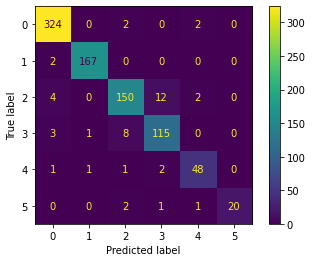

In [18]:
cm = sklearn.metrics.confusion_matrix(y_pred, y_test)
cm_plot = metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()

In [16]:
# Grid Search for SGDC

best_acc = 0
best_alpha = 0.0
best_penalty = ''

params = {
    'penalty': ['l1', 'l2'],
    'alpha': [0.1, 0.01, 0.001, 0.0001]
}

for penalty in params['penalty']:
    for alpha in params['alpha']:
        clf = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(alpha=alpha, penalty=penalty))
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        acc = metrics.accuracy_score(y_test, y_pred)
        
        print('accuracy of', acc, 'on alpha=', alpha, 'penalty=', penalty)
        
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_penalty = penalty

print('--\nbest accuracy:', best_acc, 'on alpha=', best_alpha, 'penalty=', best_penalty)

accuracy of 0.6156501726121979 on alpha= 0.1 penalty= l1
accuracy of 0.9217491369390104 on alpha= 0.01 penalty= l1
accuracy of 0.9367088607594937 on alpha= 0.001 penalty= l1
accuracy of 0.9390103567318757 on alpha= 0.0001 penalty= l1
accuracy of 0.9516685845799769 on alpha= 0.1 penalty= l2
accuracy of 0.9677790563866513 on alpha= 0.01 penalty= l2
accuracy of 0.9321058688147296 on alpha= 0.001 penalty= l2
accuracy of 0.9608745684695051 on alpha= 0.0001 penalty= l2
--
best accuracy: 0.9677790563866513 on alpha= 0.01 penalty= l2


In [ ]:
# Random Forest Implementation